## Getting Started
### Passos Necessários para colocar o Google Colab a funcionar

Dado que o Google Colab é um serviço de *cloud* gratuito e totalmente adaptado para uso de *Machine Learning*, fazia sentido usar neste trabalho, dado que simplifica toda a parte de instalação do QGIS e outras ferramentas necessárias ao projeto em causa.

In [0]:
!lsb_release -a
adicionado = False

# Repositórios necessários para o QGIS
!echo "deb     https://qgis.org/ubuntu bionic main" >> /etc/apt/sources.list
!echo "deb-src https://qgis.org/ubuntu bionic main" >> /etc/apt/sources.list

!wget -O - https://qgis.org/downloads/qgis-2019.gpg.key | apt-key add
    
# Instalação do QGIS
!apt update
!apt install qgis qgis-plugin-grass
!apt-cache policy qgis

# Necessário upgrade do IPython
!pip install IPython --upgrade

### Importar *Packages* e *Libraries* necessários 

*Import* de todos os *packages* e *libraries* necessárias para a execução do *Notebook*.

In [0]:
import os
import sys

import pandas as pd
import numpy as np
import urllib.request 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from IPython.display import Image
from osgeo import ogr
from qgis import processing
from qgis.core import *
from qgis.gui import *
from qgis.PyQt.QtGui import QColor, QImage
from qgis.PyQt.QtCore import QSize, QBuffer, QIODevice

os.environ['QT_QPA_PLATFORM'] = 'offscreen'
sys.path.insert(0,'/usr/share/qgis/python')
QgsApplication.setPrefixPath("/usr/", True)

## Importar *Datasets*
### Ler ficheiros CSV

In [0]:
# Datasets COVID-19 Mundial
covid19LocalizacoesM = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/ecdc/locations.csv")
covid19CasosM = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/ecdc/total_cases.csv")
covid19MortesM = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/ecdc/total_deaths.csv")
covid19RecuperadosM = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

# Daset COVID-19 Portugal
covid19PT1 = pd.read_csv("https://raw.githubusercontent.com/dssg-pt/covid19pt-data/master/data.csv")
covid19PT2 = pd.read_csv("https://raw.githubusercontent.com/jgrocha/covid-pt/master/situacao_epidemiologica.csv")

# Dataset Reservas Aéreas União Europeia
reservasUE = pd.read_csv("https://raw.githubusercontent.com/diogoesnog/COVID-19/master/Conjunto%20de%20Dados/Dados%20CSV/dadosReservasAereasUE.csv")

# Dataset Reservas Aéreas Portugal
reservasPT = pd.read_csv("https://raw.githubusercontent.com/diogoesnog/COVID-19/master/Conjunto%20de%20Dados/Dados%20CSV/dadosReservasAereasPT.csv")

# Dataset Apoios por Região a Microempresas Turismo Portugal
turismoRegiaoPT = pd.read_csv("https://raw.githubusercontent.com/diogoesnog/COVID-19/master/Conjunto%20de%20Dados/Dados%20CSV/dadosApoioTurismoRegiaoPT.csv")

# Dataset Apoios por Tipologia a Microempresas Turismo Portugal
turismoTipologiaPT = pd.read_csv("https://raw.githubusercontent.com/diogoesnog/COVID-19/master/Conjunto%20de%20Dados/Dados%20CSV/dadosApoioTurismoTipologiaPT.csv")

## Estudo dos Dados
### Dados Mundias

#### 1. Mapa Países Afetados
Listagem de todos Países Afetados e a contagem dos mesmos, de modo a conseguir obter uma ideia mais precisa perante o mapa apresentado a seguir.

In [0]:
def criarMapaMundialPaisesAfetados(layer):

    xt = layer.extent()
    width  = 1000
    height = 500

    options = QgsMapSettings()
    options.setLayers([layer])
    options.setBackgroundColor(QColor(255, 255, 255))
    options.setOutputSize(QSize(width, height))
    options.setExtent(xt)
              
    render = QgsMapRendererParallelJob(options)
    render.start()
    render.waitForFinished()

    image = render.renderedImage()
    return image

Layer 30Abril loaded
Layer layer_styles loaded


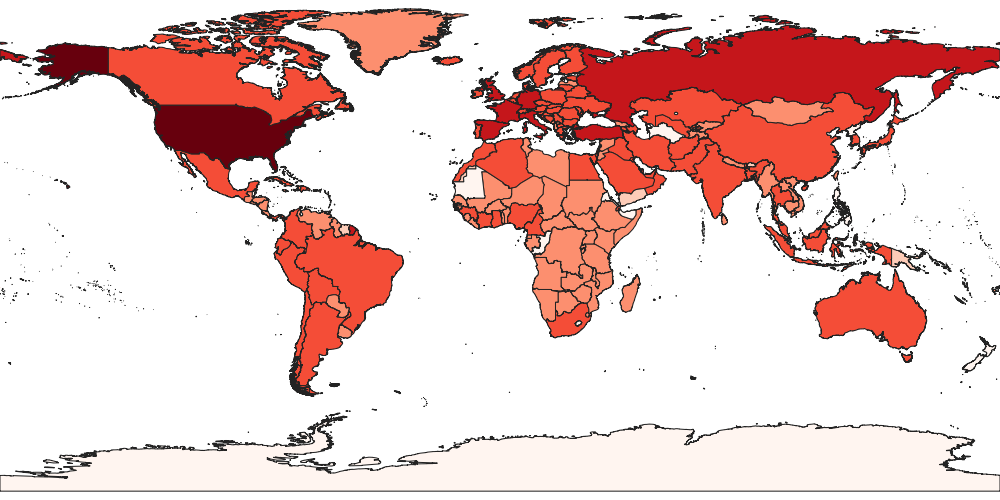

In [4]:
urllib.request.urlretrieve ("https://github.com/diogoesnog/COVID-19/raw/master/Conjunto%20de%20Dados/Mapas%20GKPG/MapaMundialPaisesAfetados.gpkg", "MapaMundialPaisesAfetados.gpkg")

mapaMundialPaisesAfetados = "MapaMundialPaisesAfetados.gpkg"
conn = ogr.Open(mapaMundialPaisesAfetados)

for i in conn:
    vlayer = QgsVectorLayer("{}|layername={}".format(mapaMundialPaisesAfetados, i.GetName()), i.GetName(), "ogr")
    if not vlayer.isValid():
        print("Layer {} failed to load".format(i.GetName()))
    else:
        QgsProject.instance().addMapLayer(vlayer)
        print("Layer {} loaded".format(i.GetName()))

finalAbril = QgsProject.instance().mapLayersByName('30Abril')[0]
image = criarMapaMundialPaisesAfetados(finalAbril)

imgbuf = QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save(imgbuf,"PNG")
Image(imgbuf.data())

In [5]:
countries = covid19LocalizacoesM['location'].unique().tolist()

print(countries)
print("\n")
print("Quantidade Países Afetados COVID-19 (Até à Data Atual do Notebook): %s" %len(countries))

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'International', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Swaziland', 'Ethiopia', 'Falkland Islands', 'Faeroe Islands', 'Fiji', 'Finland', 'France', 'French Polynesia', 'Gabon', 'Gambia', 

#### 2. Lista de Casos de COVID-19
Divulgação da quantidade de casos ativos e distinção entre as mortes e casos recuperados deste valor total.

In [6]:
print("Total Casos COVID-19 Mundial (Até à Data Atual do Notebook): %s" %"{:,}".format(covid19CasosM['World'].iloc[-1]))
print("Total Mortes COVID-19 Mundial (Até à Data Atual do Notebook): %s" %"{:,}".format(covid19MortesM['World'].iloc[-1]))
print("Total Recuperados COVID-19 Mundial (Até à Data Atual do Notebook): %s" %"{:,}".format(covid19RecuperadosM.iloc[:,-1].sum()))

Total Casos COVID-19 Mundial (Até à Data Atual do Notebook): 3,307,600
Total Mortes COVID-19 Mundial (Até à Data Atual do Notebook): 238,431
Total Recuperados COVID-19 Mundial (Até à Data Atual do Notebook): 1,052,415


#### 3. Gráficos Total Casos, Total de Mortes e relação entre os dois

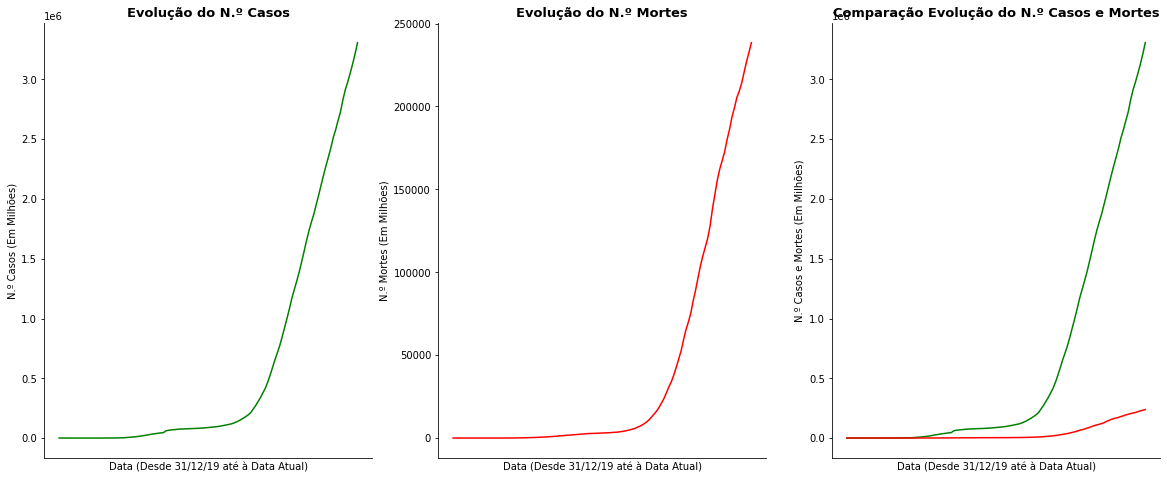

In [7]:
totalCasosMundial = covid19CasosM.sort_values(by=['date'])
x1 = totalCasosMundial.date
y1 = totalCasosMundial.World

totalMortesMundial = covid19MortesM.sort_values(by=['date'])
x2 = totalMortesMundial.date
y2 = totalMortesMundial.World

plt.figure(figsize=(20,20)).subplots_adjust(hspace=.5)

ax1 = plt.subplot(2,3,1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.xticks([])
plt.title('Evolução do N.º Casos', fontdict={'fontsize': 13, 'fontweight': 'bold'})
plt.xlabel('Data' + ' (Desde 31/12/19 até à Data Atual)')
plt.ylabel('N.º Casos' + ' (Em Milhões)')
plt.plot(x1,y1, color='green')


ax2 = plt.subplot(2,3,2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.xticks([])
plt.title('Evolução do N.º Mortes', fontdict={'fontsize': 13, 'fontweight': 'bold'})
plt.xlabel('Data' + ' (Desde 31/12/19 até à Data Atual)')
plt.ylabel('N.º Mortes' + ' (Em Milhões)')
plt.plot(x2,y2, color='red')

ax3 = plt.subplot(2,3,3)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
plt.xticks([])
plt.title('Comparação Evolução do N.º Casos e Mortes', fontdict={'fontsize': 13, 'fontweight': 'bold'})
plt.xlabel('Data' + ' (Desde 31/12/19 até à Data Atual)')
plt.ylabel('N.º Casos e Mortes' + ' (Em Milhões)')
plt.plot(x1,y1, color='green')
plt.plot(x2,y2, color='red')
plt.show()

### Dados Portugal

#### 1. Mapa Portugal Afetados
Listagem de todos os concelhos/distritos afetados, bem como o número de casos confirmados para cada um deles.

In [0]:
def criarMapasPortugal(layer):

    xt = layer.extent()
    width  = 400
    height = int(width*xt.height()/xt.width())
   
    options = QgsMapSettings()
    options.setLayers([layer])
    options.setBackgroundColor(QColor(255, 255, 255))
    options.setOutputSize(QSize(width, height))
    options.setExtent(xt)
              
    render = QgsMapRendererParallelJob(options)
    render.start()
    render.waitForFinished()

    image = render.renderedImage()
    return image

In [0]:
covid_gpkg = "covid-pt-2020-04-20.gpkg"
conn = ogr.Open(covid_gpkg)
for i in conn:
    vlayer = QgsVectorLayer("{}|layername={}".format(covid_gpkg, i.GetName()), i.GetName(), "ogr")
    if not vlayer.isValid():
        print("Layer {} failed to load".format(i.GetName()))
    else:
        QgsProject.instance().addMapLayer(vlayer)
        print("Layer {} loaded".format(i.GetName()))

from IPython.display import Image
distrito = QgsProject.instance().mapLayersByName('distrito')[0]
image = criarMapasPortugal (distrito)